# Introduction
We've received Scintillators from [Alexander Gektins group](http://isma.kharkov.ua/eng/).
According to Alexander, they are

> composite scintillator[s] on the base of the same CsI(Tl) or CsI(Na).
> It looks like a thin film made from optical (gel matrix) uploaded with scintillator (in your case it is CsI) powder.

These scintillators have been assessed with a classic [x-ray setup](https://www.psi.ch/bz/infrastruktur) (Varian RAD 14 source) at the [PSI radiation safety school](https://www.psi.ch/bz/schule-fuer-strahlenschutz).

The [iPython notebook](http://jupyter.org/) here shows the comparison of the different ISMA scintillators with a [classic CsI:Tl scintillator, commercially available from Toshiba](http://drive.globaldiagnostix.org/index.php/s/5gk1jXxG3M4yKEV).

# Materials & Methods
First we have to import some libraries we need and set some sensible defaults for outputting the plots.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
import os
import platform
import glob

# Display defaults
matplotlib.style.use('ggplot')  # Use ggplot style for plots
%matplotlib inline
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images the same way
plt.rcParams['figure.figsize'] = (16 * 0.8, 9 * 0.8)  # Display images in this size
plt.rc('lines', linewidth=2)  # Make lines a bit wider
plt.rc('lines', marker='o')  # Always with line markers
# Colors from http://tools.medialab.sciences-po.fr/iwanthue/
colors = ["#DCCB6A", "#A5C8E4", "#9ADF97", "#E9AEC8", "#77DFD3"]

Then we define often used functions, namely for reading the images from the [GDX](http://globaldiagnostix.org/) prototype electronics which we used for this experiment.

In [2]:
# Functions
def read_gray(filename, width=1280, height=4*1024):
    '''Read a .gray image from the detector to a numpy array, ready to display'''
    image = numpy.fromfile(filename, dtype=numpy.uint16, count=-1, sep='').reshape(height, width)
    return image

def reslice_image(inputimagename, ImageWidth=1280, ImageHeight=4*1024, read=True):
    '''Display 4sensor image in "human-readable" format'''
    if read:
        # Read the image from disk
        img = read_gray(inputimagename, width=ImageWidth, height=ImageHeight)
    else:
        # We already have an image, just reslice it
        img = inputimagename
    # Split into top and bottom, which we concatenate afterwards
    bottom = numpy.concatenate((img[0 * ImageHeight / 4:(0 + 1) * ImageHeight / 4, :],
                                img[1 * ImageHeight / 4:(1 + 1) * ImageHeight / 4, :]),
                               axis=1)
    top = numpy.concatenate((img[2 * ImageHeight / 4:(2 + 1) * ImageHeight / 4, :],
                             img[3 * ImageHeight / 4:(3 + 1) * ImageHeight / 4, :]),
                            axis=1)
    concatenate = numpy.concatenate((top, bottom), axis=0)
    return concatenate

def show_single_cmos(inputimagename, sensor=1, reslice=False):
    '''Display only one CMOS from 4sensor image'''
    if sensor not in [1,2,3,4]:
        print 'You have to give me a CMOS number from 1 to 4'
    if reslice:
        # We already have a full image, slice it again
        img = numpy.concatenate((inputimagename[1024:,:1280], inputimagename[1024:,1280:],
                                 inputimagename[:1024,:1280], inputimagename[:1024,1280:]))
    else:
        img = read_gray(inputimagename)     
    # Return only once CMOS region
    img = img[(sensor - 1) * 1024:sensor * 1024, :]
    return img

def display_roi(image, ZoomStartX=650, ZoomStartY=900, ZoomSize=200, color='red', prefix=''):
    '''Display an image with ROI of zoomed region plus the zoomed region'''
    from matplotlib.patches import Rectangle
    # Show image
    plt.subplot(121)
    plt.imshow(image)
    if prefix:
        plt.title('%s: Region of ROI with a size of %s px' % (prefix, ZoomSize))
    else:
        plt.title('Region of ROI with a size of %s px' % ZoomSize)        
    # Overlay zoom ROI on original image
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((ZoomStartX, ZoomStartY), ZoomSize, ZoomSize, fc=color, ec='k', alpha=0.309))
    plt.subplot(122)
    roi = image[ZoomStartY:ZoomStartY + ZoomSize, ZoomStartX:ZoomStartX + ZoomSize]
    plt.imshow(roi)
    plt.title('ROI x=%s-%s, y=%s-%s' %(ZoomStartX, ZoomStartX + ZoomSize, ZoomStartY, ZoomStartY + ZoomSize))
    return roi
    
def AskUser(Question, Choices):
    '''Ask the user to choose from several choices'''
    print(Question)
    for Counter, Item in enumerate(sorted(Choices)):
        print '    * [' + str(Counter) + ']:', Item
    Selection = []
    while Selection not in range(len(Choices)):
        try:
            Selection = int(input('Please enter the choice you want [0-%s]:' % str(len(Choices)-1)))
        except:
            print 'You actually have to select *something*'
        if Selection not in range(len(Choices)):
            print 'Try again with a valid choice'
    print 'You selected', sorted(Choices)[Selection]
    return [sorted(Choices)[Selection]]  # Return choice as single element list

After having done that, we actually perform the analysis.
To do so, we
- go through the folders (their name either contains `gkt_sct` or `gkt_gkt` for images with the Toshiba scintillator or the ISMA scintillators, respectively).
- load the images for equal source settings (`timestamp_scintillator_kV_mA`)
- define a ROI for the scintillator in question (empirically)
- plot the mean brightness and standard deviation

In [24]:
# Load images
if 'anomalocaris' in platform.node():
    # If we work locally on the Mac, load the local files
    StartPath = '/Users/habi/Dev/DemonstratorElectronics/detector2'
else:
    # Otherwise, load the files from AFS
    StartPath = '/afs/psi.ch/project/EssentialMed/Images/detector2/leadglass'
# Find all experiment folders
Folders = sorted(glob.glob(os.path.join(StartPath, '*gkt_gkt_*')))
ChooseOne = False
if ChooseOne:
    Folders = AskUser('Which folder shall I look at?', Folders)

In [25]:
kV = [None] * len(Folders)
mA = [None] * len(Folders)
for c,i in enumerate(Folders):
    kV[c] = int(i.split('_')[3])
    mA[c] = int(i.split('_')[4])
    print 'Experiment %s was acquired with %s kV and %s mA' % (os.path.basename(i), kV[c], mA[c])

Experiment 1460727023_gkt_gkt_40_40 was acquired with 40 kV and 40 mA
Experiment 1460727087_gkt_gkt_50_40 was acquired with 50 kV and 40 mA
Experiment 1460727147_gkt_gkt_60_32 was acquired with 60 kV and 32 mA
Experiment 1460727203_gkt_gkt_70_32 was acquired with 70 kV and 32 mA
Experiment 1460727260_gkt_gkt_81_10 was acquired with 81 kV and 10 mA
Experiment 1460727315_gkt_gkt_109_10 was acquired with 109 kV and 10 mA
Experiment 1460727354_gkt_gkt_46_2 was acquired with 46 kV and 2 mA
Experiment 1460727404_gkt_gkt_46_2 was acquired with 46 kV and 2 mA
Experiment 1460727478_gkt_gkt_46_4 was acquired with 46 kV and 4 mA
Experiment 1460727593_gkt_gkt_90_10 was acquired with 90 kV and 10 mA


--------------------------------------------------------------------------------
0/14: 1460727023_gkt_gkt_40_40


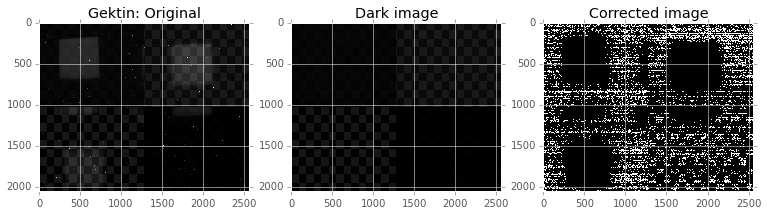

The corresponding folder for the Toshiba scintillator is 1460725350_gkt_sct_40_40


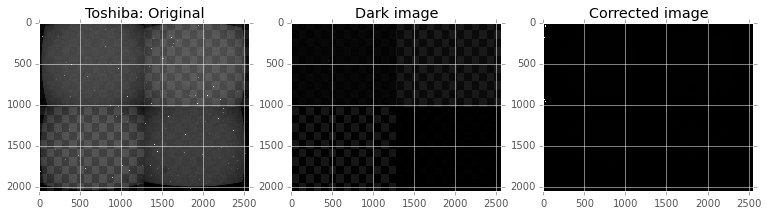

--------------------------------------------------------------------------------
1/14: 1460727087_gkt_gkt_50_40


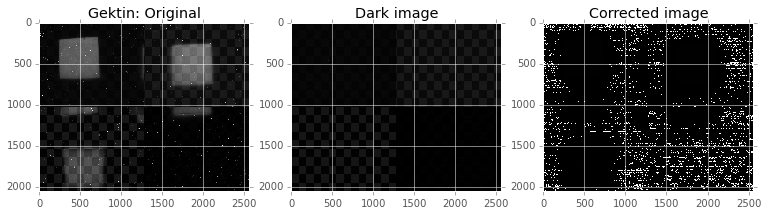

The corresponding folder for the Toshiba scintillator is 1460725409_gkt_sct_50_40


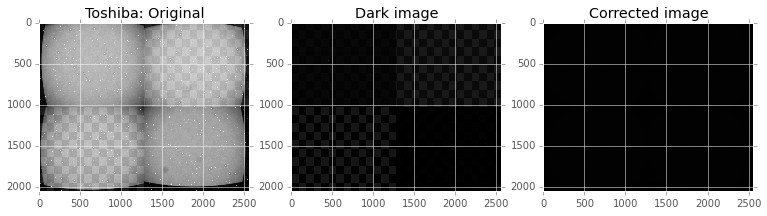

--------------------------------------------------------------------------------
2/14: 1460727147_gkt_gkt_60_32


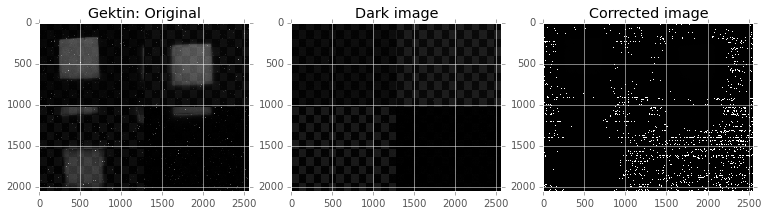

The corresponding folder for the Toshiba scintillator is 1460725577_gkt_sct_60_32


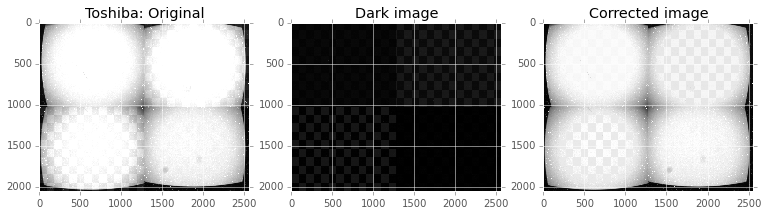

--------------------------------------------------------------------------------
3/14: 1460727203_gkt_gkt_70_32


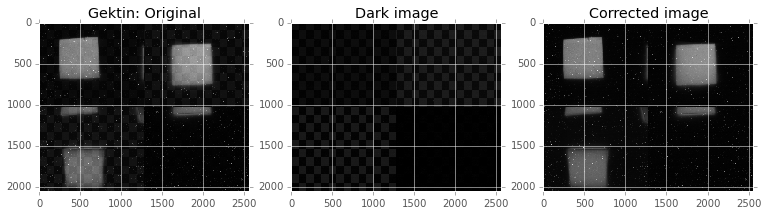

The corresponding folder for the Toshiba scintillator is 1460725705_gkt_sct_70_32


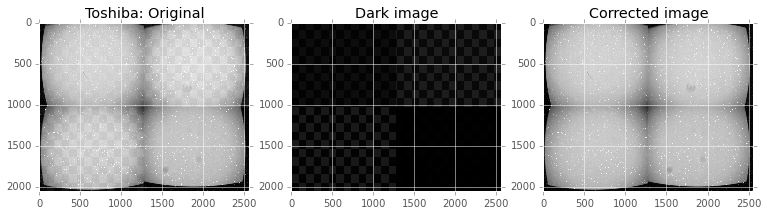

In [17]:
gkt_Image = [None] * len(Folders)
gkt_Dark = [None] * len(Folders)
gkt_Dark = [None] * len(Folders)
sct_Image = [None] * len(Folders)
sct_Dark = [None] * len(Folders)
sct_Corrected = [None] * len(Folders)

for c, i in enumerate(Folders[:4]):
    print 80 * '-'
    print '%s/%s: %s' % (c, len(Folders), os.path.basename(i))
    # Load images from Gektin
    Images = glob.glob(os.path.join(i, '*.gray'))
    # Perform dark-correction
    gkt_Image[c] = reslice_image(Images[0])
    gkt_Dark[c] = reslice_image(Images[1])
    gkt_Corrected[c] = numpy.subtract(gkt_Image, gkt_Dark)
    plt.subplot(131)
    plt.imshow(gkt_Image[c])
    plt.title('Gektin: Original')
    plt.subplot(132)
    plt.title('Dark image')
    plt.imshow(gkt_Dark[c])
    plt.subplot(133)
    plt.imshow(gkt_Corrected[c])
    plt.title('Corrected image')
    plt.show()

    # Find folder with equal settings from Toshiba scintillator
    print 'The corresponding folder for the Toshiba scintillator is %s' % os.path.basename(glob.glob(os.path.join(StartPath, '*sct_%s_%s*' % (kV[c], mA[c])))[0])
    # Then load and display this image
    ToshibaFiles = glob.glob(os.path.join(StartPath, '*sct_%s_%s*' % (kV[c], mA[c]), '*.gray'))
    sct_Image[c] = reslice_image(ToshibaFiles[0])
    sct_Dark[c] =  reslice_image(ToshibaFiles[1])
    sct_Corrected[c] = numpy.subtract(sct_Image, sct_Dark)
    plt.subplot(131)
    plt.imshow(sct_Image[c])
    plt.title('Toshiba: Original')
    plt.subplot(132)
    plt.title('Dark image')
    plt.imshow(sct_Dark[c])
    plt.subplot(133)
    plt.imshow(sct_Corrected[c])
    plt.title('Corrected image')
    plt.show()

Reading folder /afs/psi.ch/project/EssentialMed/Images/detector2/leadglass/1460727023_gkt_gkt_40_40


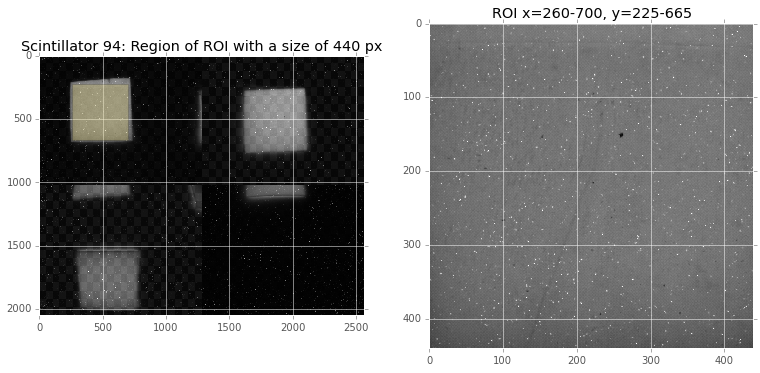

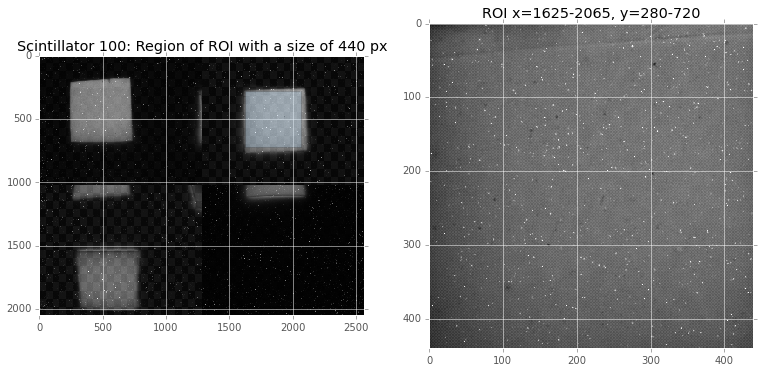

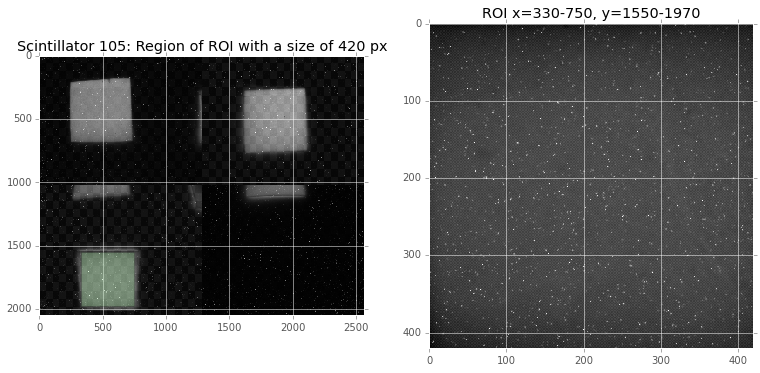

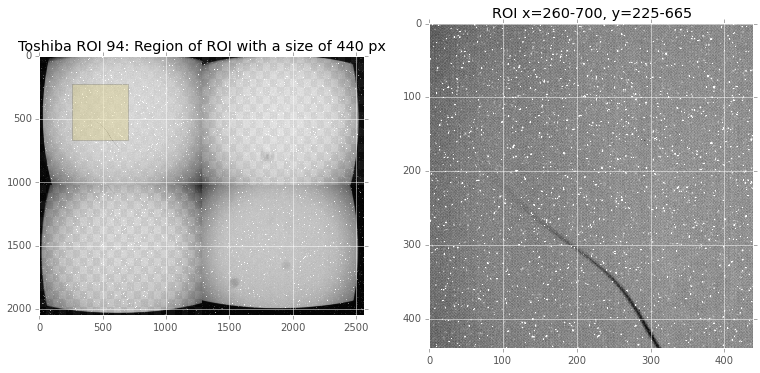

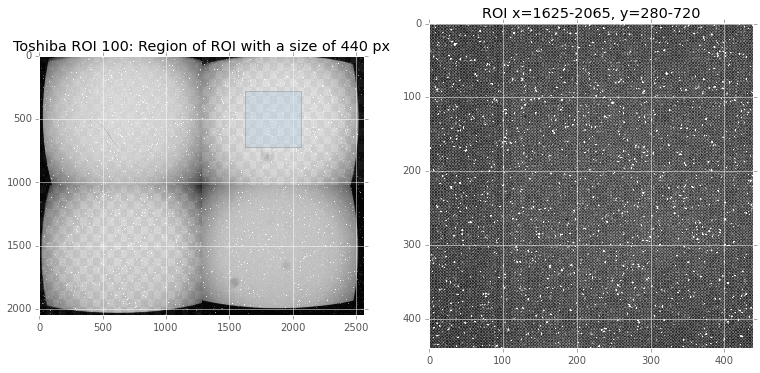

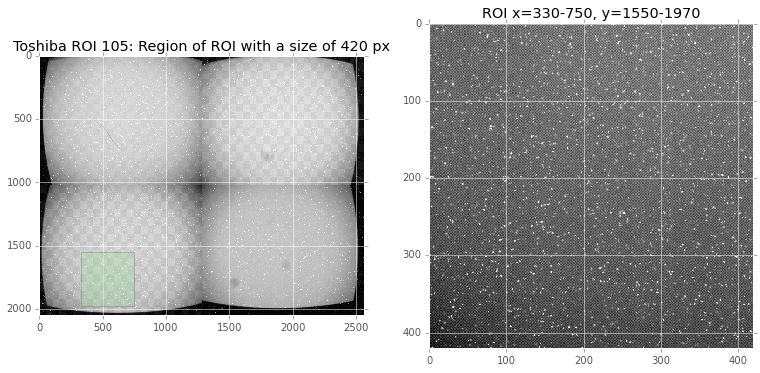

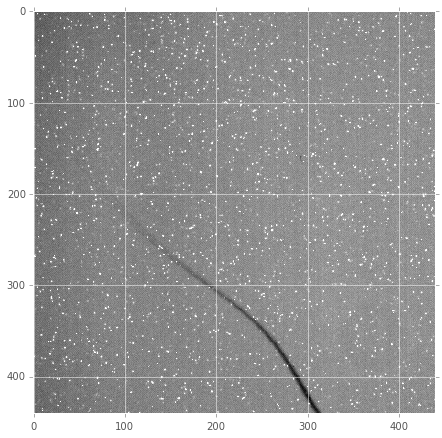

In [30]:
# Display ROI for different scintillators

# Scintillator Locations
#------------
#| 94   105 |
#| 100      |
#------------
GektinImages = [None] * len(Folders)
ToshibaImages = [None] * len(Folders)

Names = ['94', '100', '105']
ROIs = [(260,225,440), (1625,280,440), (330,1550,420)]

for c, folder in enumerate(Folders[:1]):
    # Initialize empty variables
    GektinImages[c] = [None] * 3
    ToshibaImages[c] = [None] * 3
    print 'Reading folder %s' % folder
    for i in range(3):
        GektinImages[c][i] = display_roi(gkt_Image, ROIs[i][0], ROIs[i][1], ROIs[i][2], colors[i], 'Scintillator %s' % Names[i])
        plt.show()

    for i in range(3):
        ToshibaImages[c][i] = display_roi(sct_Image, ROIs[i][0], ROIs[i][1], ROIs[i][2], colors[i], 'Toshiba ROI %s' % Names[i])
        plt.show()

In [26]:
print kV
print mA

[40, 50, 60, 70, 81, 109, 46, 46, 46, 90]
[40, 40, 32, 32, 10, 10, 2, 2, 4, 10]


In [ ]:
# Give out brightness differences 
print 'The mean brightness for the ROI of '
for i in range(3):
    print '\tScintillator %s is' % Names[i],
    print '%0.2fx brighter on the Toshiba' % (numpy.mean(ToshibaImages[i])/numpy.mean(GektinImages[i])),
    print 'vs. the ISMA scintillator (%0.f vs. %0.f, respectively)' % (numpy.mean(ToshibaImages[i]),
                                                                        numpy.mean(GektinImages[i]))
    
# STD
print 'The gray value standard deviation for the ROI of '
for i in range(3):
    print '\tScintillator %s is' % Names[i],
    print '%0.2fx smaller on the Toshiba' % (numpy.std(GektinImages[i])/numpy.std(ToshibaImages[i])),
    print 'vs. the ISMA scintillator (%0.f vs. %0.f, respectively)' % (numpy.std(ToshibaImages[i]),
                                                                        numpy.std(GektinImages[i]))